In [ ]:
try:
  import unidecode
except ModuleNotFoundError:
  !pip install pyogrio==0.7.2 geopandas==0.14.3 unidecode

In [3]:
%load_ext autoreload
%autoreload 2

import os, sys
from IPython.core.magic import register_cell_magic
from google.colab import drive
import ee
import geemap.foliumap as geemap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import fiona
import pyarrow

gpd.options.io_engine = "pyogrio"
os.environ["PYOGRIO_USE_ARROW"] = "1"

In [4]:
ee.Authenticate()
ee.Initialize(project="215656163750")
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils, explore

@register_cell_magic
def skip(line, cell):
    return

Mounted at /content/drive


In [135]:
gdb_path = "/content/drive/MyDrive/CAFO_data/USA/Iowa.gdb"
layers = fiona.listlayers(gdb_path)
print("Available layers:", layers)

def read_and_tidy(n):
  print(f"Reading layer '{layers[n]}'")
  gdf = gpd.read_file(gdb_path, layer=layers[n])
  print(len(gdf))

  # Drop extraneous columns
  to_drop = []
  for column in gdf.columns:
    for animal in ["Cattle", "Cow", "Horses", "Goats", "Sheep", "Fish"]:
      if animal in column:
        to_drop.append(column)
  for column in ["FacilityName", "Address", "City", "State", "Zip", "County",\
                 "FieldOffice", "NPDESPermitIssueDate", "PlanType",\
                 "Last_Plan_Date", "First_Plan_date", "CollectedBy",\
                 "CollectionDate", "geometry"]:
    to_drop.append(column)
  for column in to_drop:
    try:
      gdf.drop(columns=[column], inplace=True)
    except KeyError:
      pass

  # Create simplified animal columns. Convert from animal units to animal
  # numbers using conversion factors
  # THESE ARE APPROXIMATE, IN REALITY THEY DIFFER BY ANIMAL TYPE
  # SHOULD CODE THAT IN HERE
  pig_cols = [col for col in gdf.columns if 'Swine' in col]

  birds = ['Chicken', 'Turkey', 'Duck']
  poultry_cols = [col for col in gdf.columns if any(bird in col for bird in birds)]

  gdf['Number of Pigs'] = gdf[pig_cols].sum(axis=1) * 2.5
  gdf['Number of Poultry'] = gdf[poultry_cols].sum(axis=1) * 100

  # Convert facility col to int so we can match on it later
  gdf["FacilityID"] = gdf["FacilityID"].astype(int)

  # Get geometry from lat and long (original geometry is eastings + northings)
  geometry = gpd.points_from_xy(gdf.Longitude, gdf.Latitude, crs="EPSG:4326")
  gdf["geometry"] = geometry
  gdf.drop(columns=["Latitude", "Longitude"], inplace=True)

  return gdf

gdf0 = read_and_tidy(0)
gdf2 = read_and_tidy(2)

Available layers: ['animal_feeding_operations', 'AFO_open_feedlots', 'AFO_confinements']
Reading layer 'animal_feeding_operations'
10699
Index(['FacilityID', 'Latitude', 'Longitude', 'TotalAnimalUnitsByFacility',
       'OpeartionTypes', 'Unformed_Manure_Storage', 'Chicken_Layer_or_Broiler',
       'Chicken_Pullet', 'Ducks', 'Swine_Gestation____Boars_',
       'Swine_Gilts____Isolation_', 'Swine_Grow_to_Finish', 'Swine_Nursery',
       'Swine_Sow_and_Litter', 'Swine_Wean_to_Finish', 'Turkey_Finisher',
       'Turkey_Poult_or_Brooder', 'CollectionMethod', 'LocationComment'],
      dtype='object')
10699
Reading layer 'AFO_confinements'
9521
Index(['FacilityID', 'Latitude', 'Longitude', 'OperationType',
       'AnimalUnitsByOperation', 'TotalAnimalUnitsByFacility',
       'Chicken_Layer_or_Broiler__3_lbs_or_more_',
       'Chicken_Pullet__less_than_3_lbs_', 'Ducks',
       'Swine_Gestation____Boars_', 'Swine_Gilts____Isolation_',
       'Swine_Grow_to_Finish', 'Swine_Nursery', 'Swine_Sow_

Comparing gdf0 and gdf1 suggests that a single "facility" can have multiple types of "operation" (confinement and/or feedlot), and that's why TotalAnimalUnitsByFacility (gdf0 and gdf2) can exceed AnimalUnitsByOperation (gdf2 only). So I should look at AnimalUnitsByOperation in gdf2 to find the numbers of confined animals.

That means that Unformed_Manure_Storage is the only interesting column in gdf0, so let's merge that column into gdf_2 and create a new gdf. The number of confinement facilities decreases slightly, so there must be facilities in the confinement gdf that don't have corresponding IDs in the overall gdf.

In [136]:
gdf_main = gdf2.merge(gdf0[["FacilityID", "Unformed_Manure_Storage"]], on="FacilityID")

There are 8740 pigs farms 
 --The largest farm has 30306 pigs
 --3460 farms have >2500 pigs
 --These farms contain a total of 26420851 pigs
 --649 farms have 'unformed manure storage'


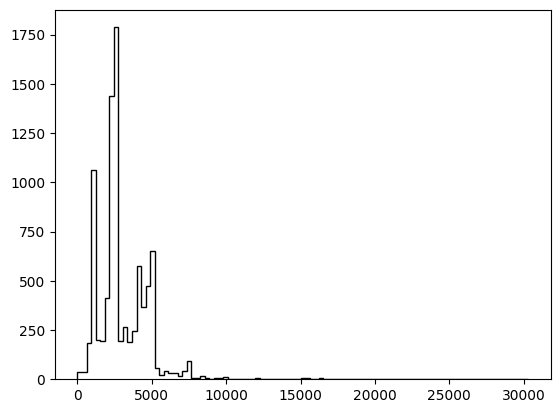

There are 266 poultry farms 
 --The largest farm has 8000000 poultry
 --143 farms have >82000 poultry
 --These farms contain a total of 91694146 poultry
 --10 farms have 'unformed manure storage'


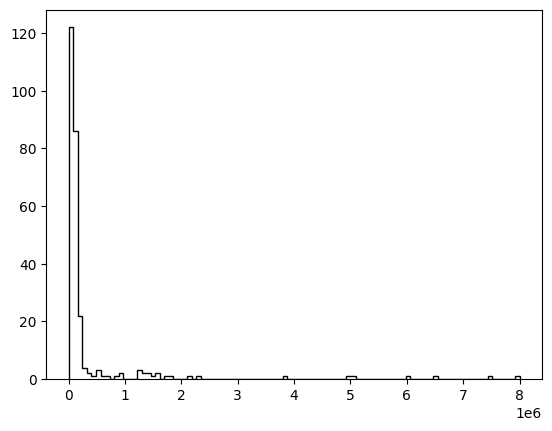

There are 479 unspecified animals farms 
 --The largest farm has 14000 unspecified animals
 --479 farms have >0 unspecified animals
 --These farms contain a total of 423514 unspecified animals
 --55 farms have 'unformed manure storage'
There are 9 farms with both types of animals
['No' 'Yes']


In [149]:

def describe(gdf, animal_col, animal_type, thresh, hist=True):
  farms = gdf[gdf[animal_col] > 0]
  print(f"There are {len(farms)} {animal_type} farms ")
  largest = farms[animal_col].max()
  print(f" --The largest farm has {largest:.0f} {animal_type}")
  print(f" --{len(farms[farms[animal_col] > thresh])} farms have >{thresh}\
 {animal_type}")
  print(f" --These farms contain a total of {farms[animal_col].sum():.0f}\
 {animal_type}")
  print(f" --{len(farms[farms['Unformed_Manure_Storage']=='Yes'])} farms have 'unformed manure storage'")

  if hist:
    bins = np.linspace(0, largest, 100)
    plt.hist(farms[animal_col], bins=bins, color='k', histtype='step')
    plt.show()

# Stats and histograms for pig and poultry farms
describe(gdf_main, 'Number of Pigs', 'pigs', 2500)
describe(gdf_main, 'Number of Poultry', 'poultry', 82000)

# These farms have numbers in the AnimalUnitsByOperation column, but
# not in the columns for individual animal types
null_farms = gdf_main[(gdf_main['Number of Pigs'] == 0) &\
                 (gdf_main['Number of Poultry'] == 0)]
describe(null_farms, 'AnimalUnitsByOperation', 'unspecified animals', 0,\
         hist=False)

# Farms with both pigs and poultry
mixed_farms = gdf_main[(gdf_main['Number of Pigs'] > 0) &\
                 (gdf_main['Number of Poultry'] > 0)]
print(f"There are {len(mixed_farms)} farms with both types of animals")

#assert len(gdf_main) == len(poultry_farms) + len(pig_farms) + len(null_farms) - len(mixed_farms)

In [52]:
# Read the Iowa state shapefile and find all buildings above 200 sq m
# We have to exclude smaller buildings to keep the data volume manageable

iowa = gpd.read_file('/content/drive/MyDrive/CAFO_data/USA/cb_2021_us_state_5m.shp')
iowa = iowa[iowa['NAME'].str.match('Iowa')]
iowa_geom = geemap.geopandas_to_ee(iowa[['geometry']])

min_building_size = 200

buildings = (
      ee.FeatureCollection(f"projects/sat-io/open-datasets/VIDA_COMBINED/USA")
      .filter(ee.Filter.gt('area_in_meters', min_building_size))
      .filterBounds(iowa_geom)
)

In [150]:
#%%skip
# Save the buildings to a file for future use. This is time-consuming so leave
# this cell commented out unless there's a reason to recreate the file.

utils.write_to_file(buildings, f"IA_{min_building_size}m2", 'USA')
utils.ee_task_status()

Task MZGNX7LWUVHYGBHNTLOI3S3P started at 2024-08-14 03:16:29.036000
Current status: COMPLETED
Task XRHCRQ3LP4KCZG4SNFB3HWOE started at 2024-08-14 03:15:57.791000
Current status: COMPLETED
Task 3HWMJAEAKIJWWXRTX3JTZ4H7 started at 2024-08-08 01:23:53.703000
Current status: COMPLETED
Task H36ME664KMRK76O4RV3DIA2P started at 2024-08-08 01:23:53.708000
Current status: COMPLETED
Task PT3OJIIL54DO2X2XBHGHRXZN started at 2024-08-08 01:23:45.911000
Current status: COMPLETED


In [151]:
# Read the data into a geodataframe (takes about 1.5 mins, ~700,000 buildings)

gdf = gpd.read_file(f"/content/drive/MyDrive/CAFO_data/USA/IA_{min_building_size}m2.geojson")
gdf.rename(columns={"area_in_meters": "Area (sq m)"}, inplace=True)
print(f"There are {len(gdf)} buildings > {min_building_size} sq m")

There are 738413 buildings > 200 sq m


In [ ]:
# Now get the farm-associated buildings. For whole df or for pig and poultry subsets, separately?